In [ ]:
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.10.0
    Uninstalling keras-3.10.0:
      Successfully uninstalled keras-3.10.0


In [ ]:
!pip install tensorflow

## **Getting Dataset**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/sports-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sports-classification' dataset.
Path to dataset files: /kaggle/input/sports-classification


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras

In [ ]:
import numpy as np
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

## **Explore Dataset**

In [ ]:
def count_images_in_folders(dataset_path):
    for folder_name in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder_name)
        if os.path.isdir(folder_path):
            image_count = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])
            print(f"Folder: {folder_name}, Images: {image_count}")

print("Training set image counts:")
count_images_in_folders(f"{path}/train")

Training set image counts:
Folder: bobsled, Images: 138
Folder: hurdles, Images: 136
Folder: snow boarding, Images: 117
Folder: fly fishing, Images: 134
Folder: luge, Images: 127
Folder: sidecar racing, Images: 133
Folder: ampute football, Images: 112
Folder: volleyball, Images: 142
Folder: billiards, Images: 145
Folder: giant slalom, Images: 150
Folder: tennis, Images: 131
Folder: horse racing, Images: 139
Folder: pole dancing, Images: 112
Folder: figure skating women, Images: 157
Folder: rollerblade racing, Images: 159
Folder: fencing, Images: 135
Folder: olympic wrestling, Images: 167
Folder: golf, Images: 157
Folder: ultimate, Images: 97
Folder: harness racing, Images: 147
Folder: football, Images: 191
Folder: frisbee, Images: 131
Folder: bungee jumping, Images: 125
Folder: shot put, Images: 149
Folder: ice climbing, Images: 130
Folder: figure skating men, Images: 128
Folder: rowing, Images: 143
Folder: bike polo, Images: 110
Folder: swimming, Images: 157
Folder: judo, Images: 150


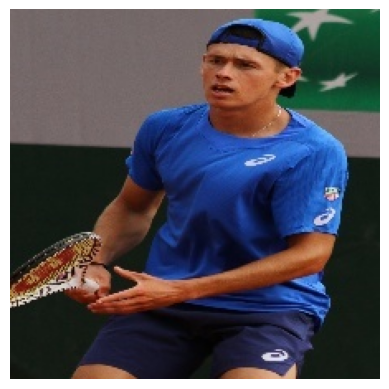

In [ ]:
import matplotlib.pyplot as plt

image_path = f"{path}/train/tennis/001.jpg"
img = plt.imread(image_path)
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
train_path = f"{path}/train"
evaluation_path = f"{path}/valid"
test_path = f"{path}/test"

## **Preprocessing and Generate a Dataset**

In [ ]:
image_size = (224, 224)
batch_size = 32

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    train_path,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
)

Found 13492 files belonging to 100 classes.


In [ ]:
evaluation_ds = keras.utils.image_dataset_from_directory(
    evaluation_path,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
)

Found 500 files belonging to 100 classes.


In [ ]:
test_ds = keras.utils.image_dataset_from_directory(
    test_path,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
)

Found 500 files belonging to 100 classes.


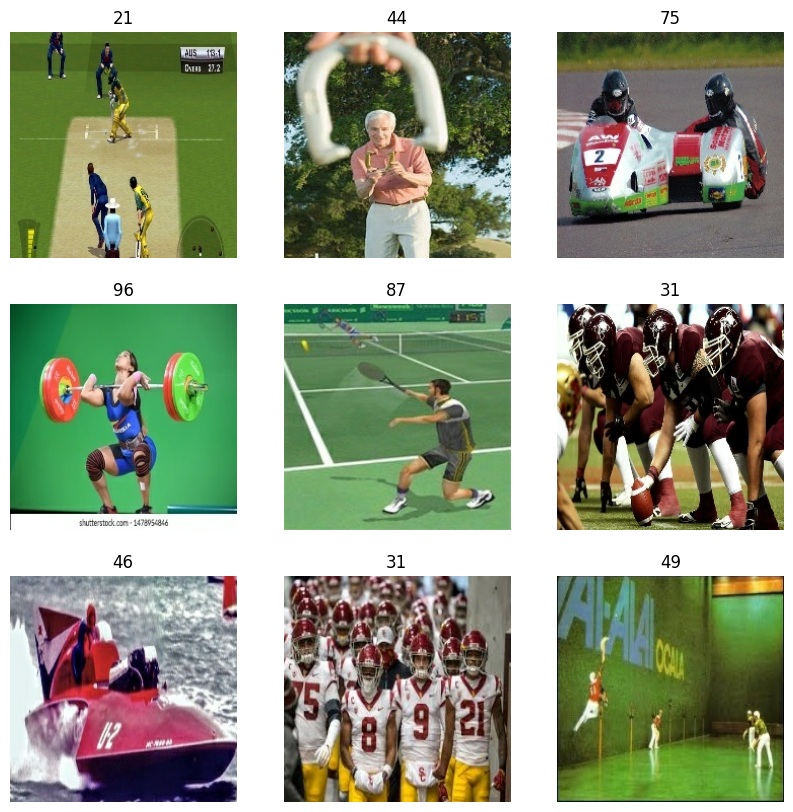

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(5):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(labels[i].numpy().argmax())
        plt.axis("off")

## **Data augmentation**

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

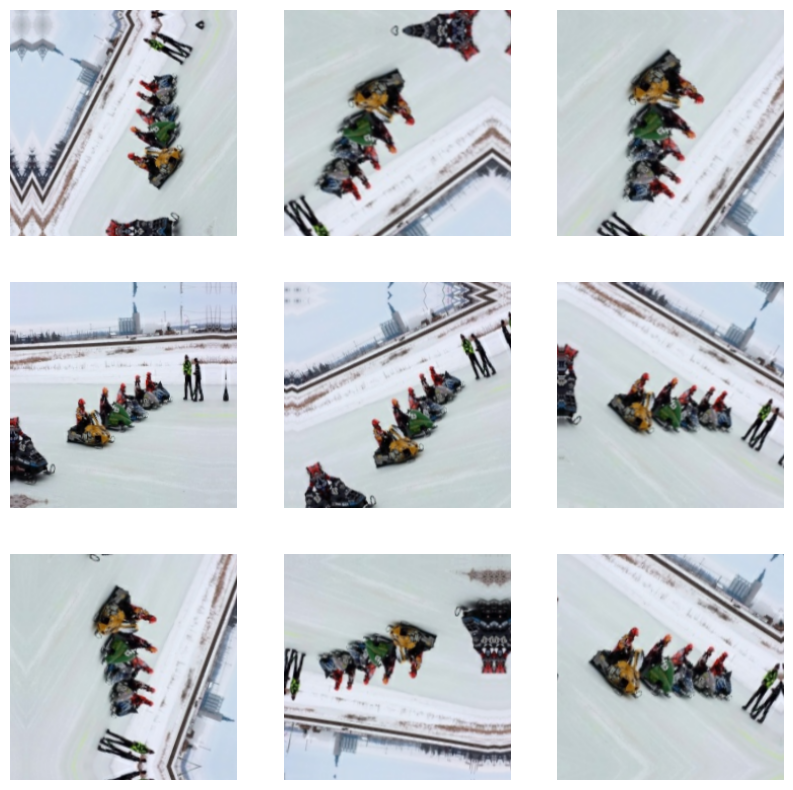

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
evaluation_ds = evaluation_ds.prefetch(tf_data.AUTOTUNE)

## **Build the Model**

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten
from keras.layers import Rescaling, RandomFlip, RandomRotation, Dropout
from keras.layers import RandomZoom, RandomTranslation, BatchNormalization, GlobalAveragePooling2D
import tensorflow as tf

image_size = (224, 224)
num_classes = 100

inputs = tf.keras.Input(shape=(image_size[0], image_size[1], 3))

# Data Augmentation
x = Rescaling(1./255)(inputs)
x = RandomFlip("horizontal")(x)
x = RandomRotation(0.1)(x)
x = RandomZoom(0.1)(x)
x = RandomTranslation(0.1, 0.1)(x)

x = Conv2D(64, 7, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Conv2D(64, 1, padding='same', activation='relu')(x)
x = Conv2D(192, 3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Conv2D(192, 3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Conv2D(256, 3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Conv2D(512, 3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='CategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_11 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_12 (RandomFlip)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_12              │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_12 (RandomZoom)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_12           │ (None, 224, 224, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 224, 224, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 112, 112, 64)   │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 112, 112, 192)  │       110,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 112, 112, 192)  │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 56, 56, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 56, 56, 192)    │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 56, 56, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 28, 28, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 28, 28, 256)    │       442,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,711,844 (10.34 MB)

 Trainable params: 2,709,412 (10.34 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [ ]:
from keras.callbacks import EarlyStopping

epochs = 80

early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    min_delta=0.001,        # Minimum change to be considered an improvement
    patience=10,            # Stop after 10 epochs with no improvement
    mode='min',             # Minimize the validation loss
    restore_best_weights=True # Restore weights from the best epoch
)

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    early_stopping,
]

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=evaluation_ds,
)

Epoch 1/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 40s 75ms/step - accuracy: 0.0648 - loss: 4.2302 - val_accuracy: 0.0320 - val_loss: 5.2991
Epoch 2/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.1163 - loss: 3.7881 - val_accuracy: 0.1600 - val_loss: 3.7026
Epoch 3/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.1432 - loss: 3.5883 - val_accuracy: 0.1340 - val_loss: 3.6961
Epoch 4/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.1699 - loss: 3.4356 - val_accuracy: 0.1160 - val_loss: 3.7155
Epoch 5/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.1851 - loss: 3.3194 - val_accuracy: 0.1660 - val_loss: 3.5486
Epoch 6/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.2036 - loss: 3.2161 - val_accuracy: 0.1380 - val_loss: 3.5880
Epoch 7/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.2265 - loss: 3.1040 - val_accuracy: 0.1920 - val_loss: 3.3288
Epoch 8/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.2460 - loss: 3.0241 - 

## **Predict**

In [ ]:
!ls /root/.cache/kagglehub/datasets/gpiosenka/sports-classification/versions/9/test/golf

ls: cannot access '/root/.cache/kagglehub/datasets/gpiosenka/sports-classification/versions/9/test/golf': No such file or directory


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


np.int64(36)

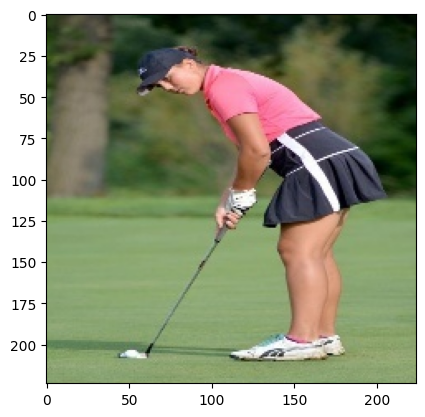

In [ ]:
img = keras.utils.load_img(f"{path}/test/golf/5.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
sport = predictions[0].argmax()
sport

### **Evaluation of Model**

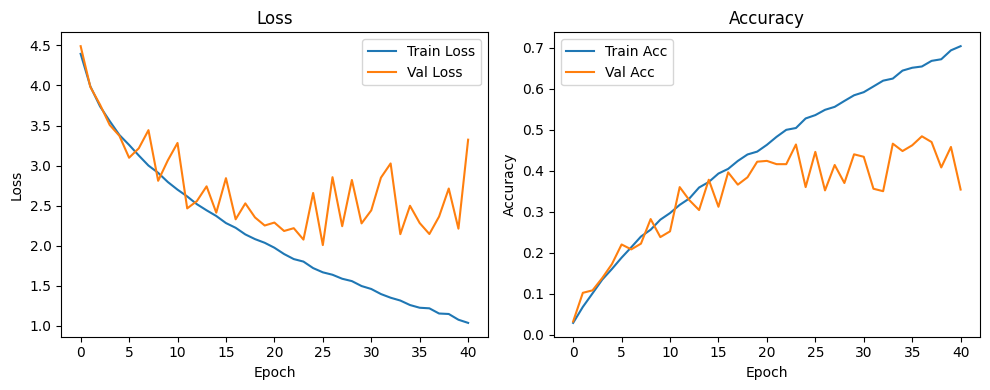

In [ ]:
import matplotlib.pyplot as plt

# Get values
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history.get('accuracy')
val_acc = history.history.get('val_accuracy') or history.history.get('val_acc')

# Plot Loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(np.argmax(labels, axis=1))
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:")
print(classification_report(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Accuracy: 0.434
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       1.00      0.20      0.33         5
           2       0.00      0.00      0.00         5
           3       0.33      0.20      0.25         5
           4       0.25      0.60      0.35         5
           5       0.60     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


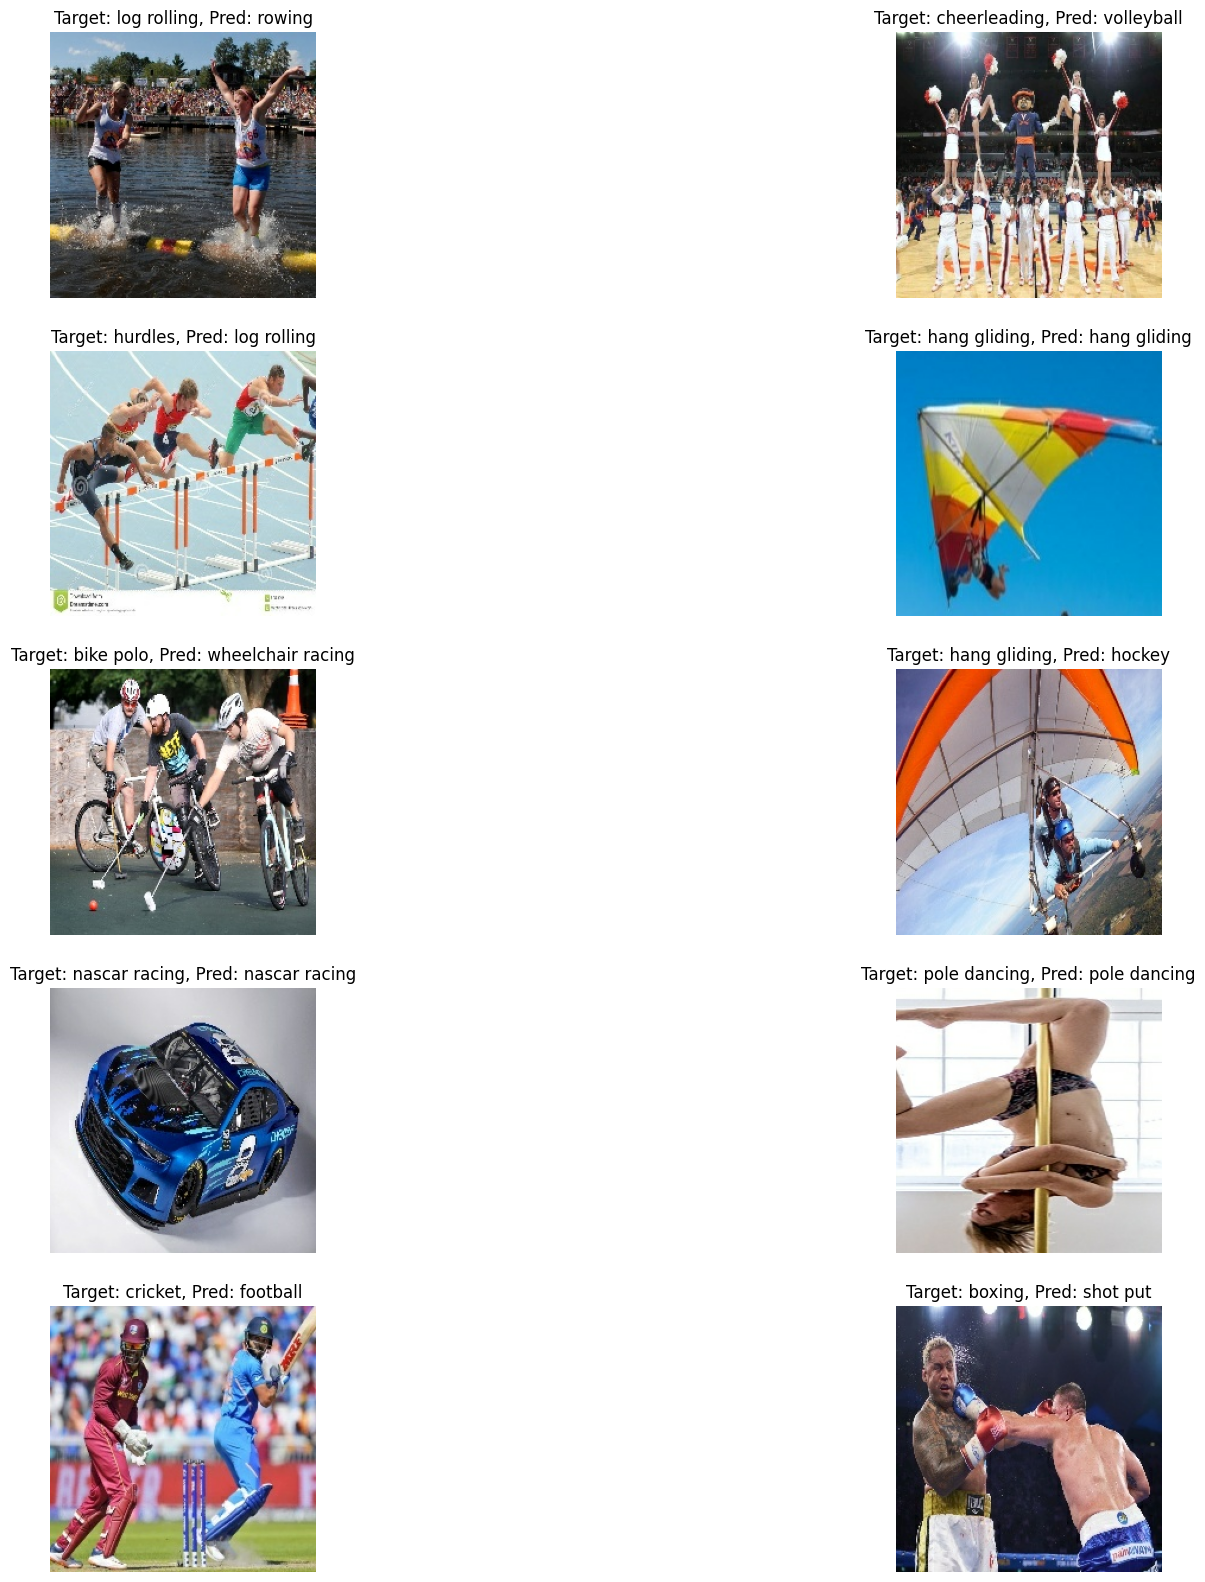

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_samples(images, true_labels, pred_labels, class_names, sample_count=10):
    plt.figure(figsize=(20, 20))
    for i in range(sample_count):
        plt.subplot(5, 2, i + 1)
        plt.imshow(images[i].astype("uint8"))
        true_label_name = class_names[true_labels[i]]
        pred_label_name = class_names[pred_labels[i]]
        plt.title(f"Target: {true_label_name}, Pred: {pred_label_name}")
        plt.axis('off')
    plt.show()

# Get class names from the test dataset
class_names = test_ds.class_names

# Collect images, true labels, and predicted labels from the test dataset
all_images = []
all_true_labels = []
all_pred_labels = []

for images, labels in test_ds:
    all_images.extend(images)
    all_true_labels.extend(np.argmax(labels, axis=1))
    predictions = model.predict(images)
    all_pred_labels.extend(np.argmax(predictions, axis=1))

all_images = np.array(all_images)
all_true_labels = np.array(all_true_labels)
all_pred_labels = np.array(all_pred_labels)

display_samples(all_images, all_true_labels, all_pred_labels, class_names, sample_count=10)

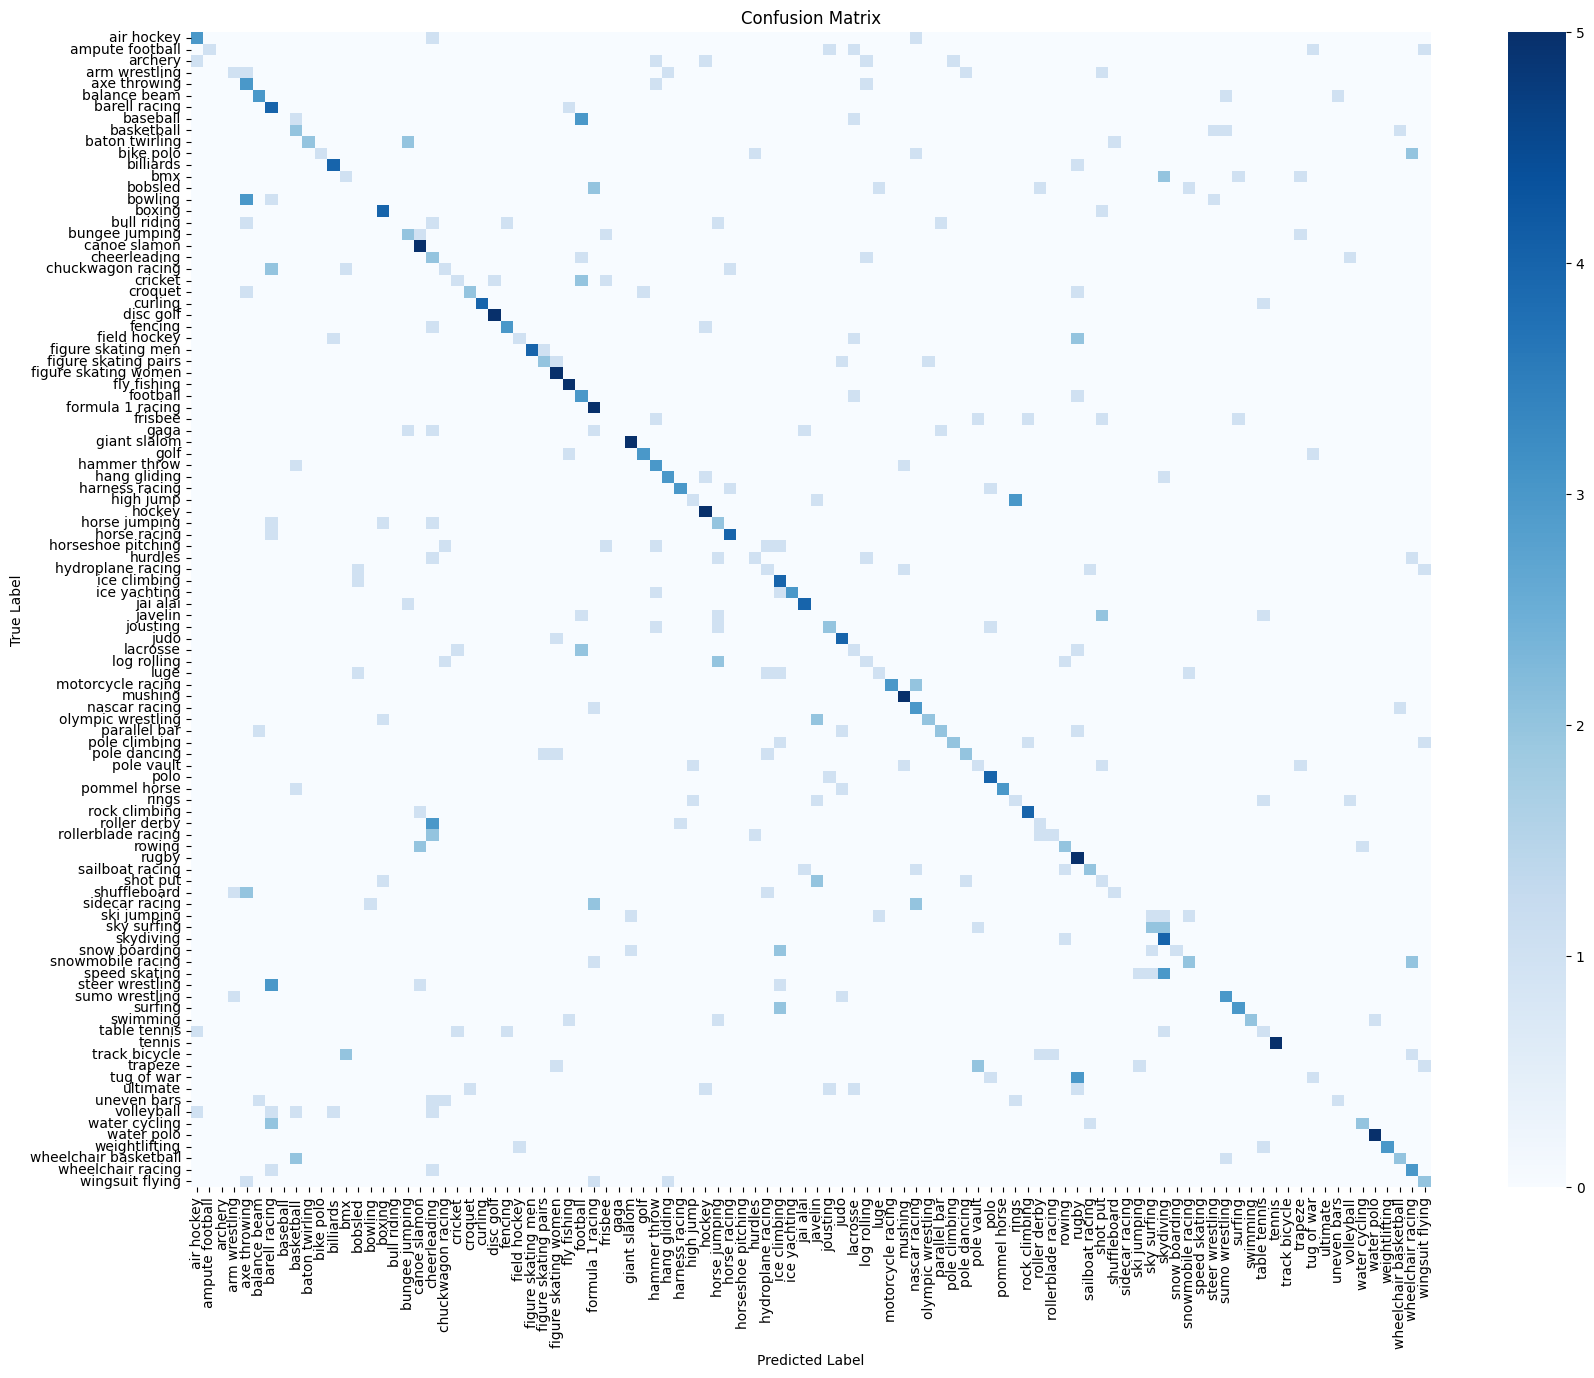

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class names
class_names = test_ds.class_names

plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('model-sports-image-classification-custom.keras')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
import os

source_path = 'model-sports-image-classification-custom.keras'
destination_path = '/content/drive/MyDrive/Personal/Maestria IA/Deep Learning/Taller 2/model-sports-image-classification-custom.keras'

shutil.copy(source_path, destination_path)

print(f"Model saved to: {destination_path}")

Model saved to: /content/drive/MyDrive/Personal/Maestria IA/Deep Learning/Taller 2/model-sports-image-classification-custom.keras


## **Grad-CAM class activation visualization**
The Grad-CAM algorithm is a technique that produces a visual "heatmap" to show what parts of an image a Convolutional Neural Network (CNN) is focusing on to make a decision. It's an interpretability tool that helps us understand the "why" behind a prediction.

In essence, Grad-CAM (Gradient-weighted Class Activation Mapping) allows you to see which regions of an input image were most important for the model to classify it with a specific label

The Grad-CAM algorithm

References:
- https://keras.io/examples/vision/grad_cam/
- https://www.pinecone.io/learn/class-activation-maps/

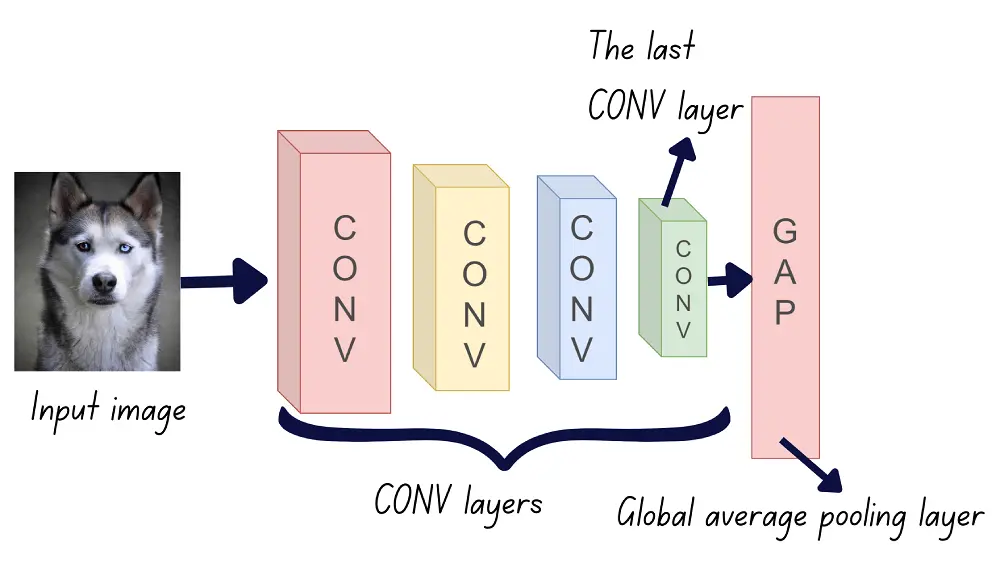

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
def make_gradcam_heatmap(img_array, backbone, last_conv_layer, class_index):
    last_conv_layer = backbone.get_layer(last_conv_layer).output
    grad_model = tf.keras.Model(inputs=backbone.input, outputs=last_conv_layer)

    with tf.GradientTape() as tape:
        conv_outputs = grad_model(img_array)
        tape.watch(conv_outputs)
        class_score = tf.reduce_mean(conv_outputs[..., :])

    grads = tape.gradient(class_score, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()


In [ ]:
import cv2
import matplotlib.pyplot as plt

def display_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img.astype(np.uint8), 1-alpha, heatmap, alpha, 0)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

Processing image 1: Target: log rolling, Predicted: rowing


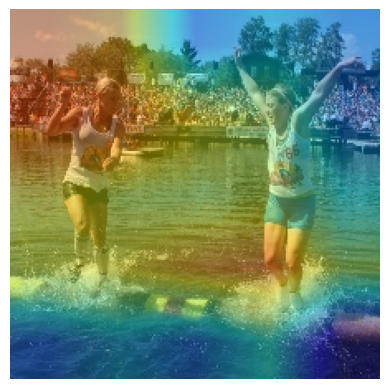

Processing image 2: Target: cheerleading, Predicted: volleyball


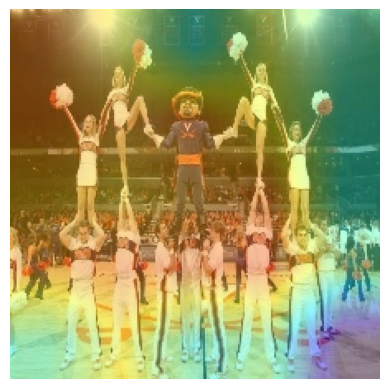

Processing image 3: Target: hurdles, Predicted: log rolling


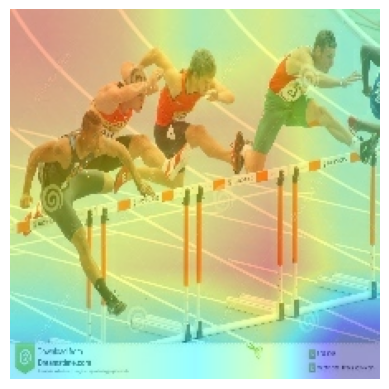

Processing image 4: Target: hang gliding, Predicted: hang gliding


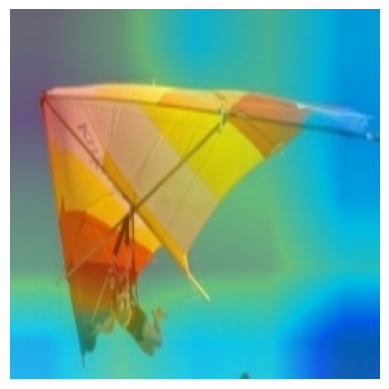

Processing image 5: Target: bike polo, Predicted: wheelchair racing


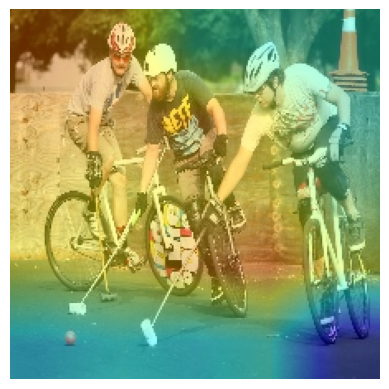

Processing image 6: Target: hang gliding, Predicted: hockey


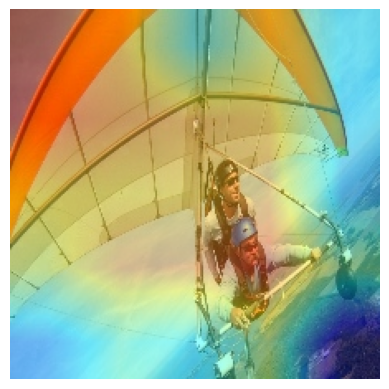

Processing image 7: Target: nascar racing, Predicted: nascar racing


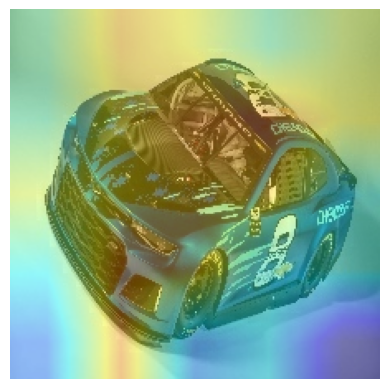

Processing image 8: Target: pole dancing, Predicted: pole dancing


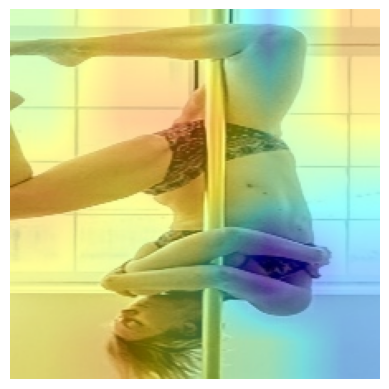

Processing image 9: Target: cricket, Predicted: football


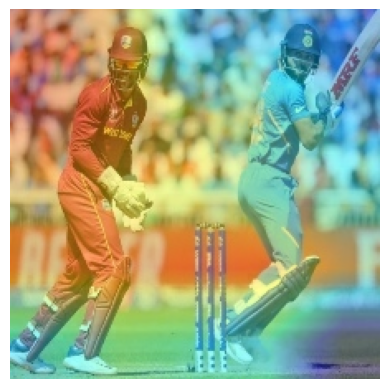

Processing image 10: Target: boxing, Predicted: shot put


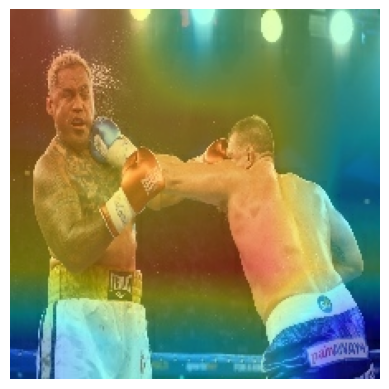

In [ ]:
for i in range(len(all_images[:10])):
    img = all_images[i]
    img_array = np.expand_dims(img / 255.0, axis=0)

    true_label = class_names[all_true_labels[i]]
    pred_label = class_names[all_pred_labels[i]]

    print(f"Processing image {i+1}: Target: {true_label}, Predicted: {pred_label}")

    class_index = all_pred_labels[i]

    # Grad-CAM over backbone
    heatmap = make_gradcam_heatmap(img_array, model, "conv2d_47", class_index)

    display_gradcam(img, heatmap)
